In [1]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, prob_dropout=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # mod here
        # self.dropout1 = nn.Dropout2d(p=prob_dropout)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        

        # mod here
        # self.dropout2 = nn.Dropout2d(p=prob_dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()



print("done")

done


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

torch.manual_seed(1024)

def load_cifar_batch1(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch1('cifar-10-batches-py/batches.meta')
label_names = meta_data_dict[b'label_names']


def load_cifar_batch(file, transform=None):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    images = batch[b'data']
    if len(batch) > 2:
        labels = batch[b'labels']
    num_images = images.shape[0]
    
    # Reshape the images into the correct format: N x H x W x C
    # print(images)
    # images = images.reshape((num_images, 3, 32, 32)).transpose(0, 2, 3, 1).astype(np.float32)
    
    # for print out
    images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

    # plt.figure(figsize=(20, 4))
    # for i in range(10):
    #     plt.subplot(1, 10, i+1)
    #     plt.imshow(images[i])
    #     plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    #     plt.axis('off')
    # plt.show()
    
    min_val = np.min(images)
    max_val = np.max(images)
    images = (images - min_val) / (max_val - min_val) #normalizing facepalm

    # print(images)
    # images = images.reshape((num_images, 3, 32, 32)).astype(np.float32)
    # Initialize a list to store processed images
    processed_images = []


    # Apply transformations if any
    for i,image in enumerate(images):
        if transform is not None:
            # Convert numpy array to PIL Image to apply transformation
            pil_image = Image.fromarray((image * 255).astype(np.uint8))
            # Apply transformation
            pil_image = transform(pil_image)
       
            tup = (pil_image, labels[i])
            # Append transformed image
            processed_images.append(tup)
        else:
            # Convert to tensor without transformation
            torch.tensor(image, dtype=torch.float32) / 255.0
            processed_images.append(image, labels[i])
    # print(processed_images[:1])
    return processed_images



test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# transformation for train data 
train_transform = transforms.Compose([
    transforms.RandomRotation(10), # Add random rotation with 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    transforms.RandomHorizontalFlip(), #apply horizontal flipping
    transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(), # Randomly flip the images on the horizontal axis
    transforms.RandomRotation(10), # Randomly rotate the images by +/- 10 degrees
    # transforms.RandomCrop(32, padding=4), # Apply random crops
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_files = ['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5']
trainarr = []
trainlabel = None

for file in batch_files:
    # Load CIFAR-10 batch
    batch = load_cifar_batch(file, transform=train_transform)
    for item in batch:
        trainarr.append(item)
    # print(type(trainarr))
    



# print(type(trainarr))
batch_size = 16
trainDataLoader = torch.utils.data.DataLoader(trainarr, batch_size=batch_size,shuffle=True)
# trainDataLoaderLabels = torch.utils.data.DataLoader(trainlabel, batch_size=batch_size,shuffle=True)
# print(next(iter(trainDataLoader)))
# print(len(trainarr))
# print(trainarr[40000:40030])


test_images = load_cifar_batch('cifar-10-batches-py/test_batch', transform=test_transform)
testDataLoader = torch.utils.data.DataLoader(test_images, batch_size=batch_size,shuffle=True)
# testDataLoaderLabels = torch.utils.data.DataLoader(test_labels, batch_size=batch_size,shuffle=True)

# images = next(iter(trainDataLoader))
# labels = next(iter(trainDataLoaderLabels))
print(len(trainDataLoader))
# for batch in trainDataLoader:
#     print(batch)

3125


In [12]:
import torch.optim.lr_scheduler as lr_scheduler
# from torch.optim.lr_scheduler import StepLR 


input_size = 28 # each input token is a row of a FashionMNIST image so 28 pixels
hidden_size=128 # hidden representation size
num_layers = 2  # two-layer LSTM
num_classes = 10
num_epochs=18
learning_rate= 0.01


model = ResNet18().cuda()
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
# optimizer = torch.optim.SGD(model.parameters(), lr=.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# overfitting
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-5)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=18)  # T_max is typically set to the number of epochs
print("done")

done


In [13]:
total_step = len(trainDataLoader)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: ", num_params)

train_loss_history = []
test_loss_history = []
matches = 0
total = 0

for epoch in range(num_epochs):
  train_loss = 0.0
  test_loss = 0.0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    # forward
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness

    # backwards
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()
    if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, fit.item()))
  # model.eval()
  # for i, data in enumerate(testDataLoader):
  #   with torch.no_grad():
  #     images, labels = data
  #     images = images.cuda()
  #     labels = labels.cuda()
  #     predicted_output = model(images)
  #     fit = loss(predicted_output, labels)
  #     test_loss += fit.item()
  #     _, predicted = torch.max(predicted_output.data, 1)
  #     matches += (predicted == labels).sum().item()
  #     total += labels.size(0)
  # train_loss = train_loss / len(trainDataLoader)
  # test_loss = test_loss / len(testDataLoader)
  # train_loss_history += [train_loss]
  # test_loss_history += [test_loss]
  # print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
    # scheduler.step()
# train_loss_history = []
# test_loss_history = []
# matches = 0
# total = 0


# for epoch in range(80):
#   train_loss = 0.0
#   test_loss = 0.0

#   model.train()
#   for i, data in enumerate(trainDataLoader):
#     images, labels = data
#     images = images.cuda()
#     labels = labels.cuda()
#     optimizer.zero_grad() # zero out any gradient values from the previous iteration
#     predicted_output = model(images) # forward propagation
#     fit = loss(predicted_output, labels)  # calculate our measure of goodness
#     fit.backward() # backpropagation
#     optimizer.step() # update the weights of our trainable parameters
#     train_loss += fit.item()

#   model.eval()
#   for i, data in  enumerate(testDataLoader):
#     with torch.no_grad():
#       images, labels = data
#       images = images.cuda()
#       labels = labels.cuda()
#       predicted_output = model(images)
#       fit = loss(predicted_output, labels)
#       test_loss += fit.item()
#       _, predicted = torch.max(predicted_output.data, 1)
#       matches += (predicted == labels).sum().item()
#       total += labels.size(0)
#   train_loss = train_loss / len(trainDataLoader)
#   test_loss = test_loss / len(testDataLoader)
#   train_loss_history += [train_loss]
#   test_loss_history += [test_loss]
#   # scheduler.step()
#   print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
print("done")

Number of parameters:  11173962
Epoch [1/18], Step [100/3125], Loss: 2.19
Epoch [1/18], Step [200/3125], Loss: 2.41
Epoch [1/18], Step [300/3125], Loss: 1.83
Epoch [1/18], Step [400/3125], Loss: 2.03
Epoch [1/18], Step [500/3125], Loss: 1.82
Epoch [1/18], Step [600/3125], Loss: 1.76
Epoch [1/18], Step [700/3125], Loss: 1.58
Epoch [1/18], Step [800/3125], Loss: 2.19
Epoch [1/18], Step [900/3125], Loss: 1.09
Epoch [1/18], Step [1000/3125], Loss: 1.51
Epoch [1/18], Step [1100/3125], Loss: 1.38
Epoch [1/18], Step [1200/3125], Loss: 1.98
Epoch [1/18], Step [1300/3125], Loss: 1.77
Epoch [1/18], Step [1400/3125], Loss: 1.18
Epoch [1/18], Step [1500/3125], Loss: 1.73
Epoch [1/18], Step [1600/3125], Loss: 1.80
Epoch [1/18], Step [1700/3125], Loss: 0.91
Epoch [1/18], Step [1800/3125], Loss: 1.65
Epoch [1/18], Step [1900/3125], Loss: 1.25
Epoch [1/18], Step [2000/3125], Loss: 1.46
Epoch [1/18], Step [2100/3125], Loss: 0.88
Epoch [1/18], Step [2200/3125], Loss: 1.68
Epoch [1/18], Step [2300/3125],

In [14]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in testDataLoader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test accuracy: {100 * correct / total}%')

# ~10 epochs = 81.5%?
# ~13 = Test accuracy: 79.6%

Test accuracy: 80.91%


In [15]:
# CHECK ACCURACY 
import pickle
import pandas as pd
import numpy as np
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_images_nl = unpickle('cifar_test_nolabels.pkl')[b'data']
test_images_nl2 = unpickle('cifar_test_nolabels.pkl')[b'data']
test_images_nl_id = unpickle('cifar_test_nolabels.pkl')[b'ids'].tolist()

test_images_nl = test_images_nl.reshape((-1, 3, 32, 32))
min_val = np.min(test_images_nl)
max_val = np.max(test_images_nl)
test_images_nl = (test_images_nl - min_val) / (max_val - min_val) #normalizing facepalm

test_images_nl2 = test_images_nl2.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0

# print(test_images_nl)
# print("rawr")
# print(test_images_nl2)

# plt.figure(figsize=(20, 4))
# for i in range(10):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(test_images_nl[i])
#     plt.axis('off')
# plt.show()



test_images_tensor_nl = torch.tensor(test_images_nl, dtype=torch.float32)
testDataLoaderNL = torch.utils.data.DataLoader(test_images_tensor_nl, batch_size=1,shuffle=False)


predictions = []
model.eval()
for image in testDataLoaderNL:
    image = image.cuda()
    with torch.no_grad():
        output = model(image)

    # _, predicted_class = torch.max(output, 1)
    # predictions.append(predicted_class.item())

    # Preprocess the image if necessary
    # Perform inference
    # Here we assume 'resnet' is already loaded and 'image' is preprocessed
    output = model(image)
    # Perform post-processing if necessary
    # Append the prediction to the predictions list
    predictions.append(output.argmax().item())

print(len(predictions))
# # print(test_images_nl_id)


10000


In [36]:
def calculate_accuracy(predictions, actual):
    if len(predictions) != len(actual):
        raise ValueError("Length of predictions and actual arrays must be the same.")
    
    num_matches = sum(1 for pred, act in zip(predictions, actual) if pred == act)
    accuracy = (num_matches / len(predictions)) * 100
    return accuracy


actual = []
pattern = [8, 2, 9, 0, 4, 3, 6, 1, 7, 5]
for num in pattern:
    actual.extend([num] * 1000)
calculate_accuracy(predictions, actual)

49.41

In [43]:
# Create a DataFrame with IDs and labels
df = pd.DataFrame({
    'ID': test_images_nl_id,
    'Labels': predictions
})

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)

print("done")

done


In [44]:

# Define the number of groups
num_groups = 10

# Calculate the size of each group
group_size = len(predictions) // num_groups

# print(predictions[:50]) #8
# print(predictions[1000:1050]) #2
# print(predictions[2000:2050]) #9
# print(predictions[3000:3050]) #0
# print(predictions[4000:4050]) #4
# print(predictions[5000:5050]) #3
# print(predictions[6000:6050]) #6
# print(predictions[7000:7050]) #1
# print(predictions[8000:8050]) #7
# print(predictions[9000:9050]) #5
should = {
    0: ['8', predictions[:50]],
    1: ['2', predictions[1000:1050]],
    2: ['9', predictions[2000:2050]],
    3: ['0', predictions[3000:3050]],
    4: ['4', predictions[4000:4050]],
    5: ['3', predictions[5000:5050]],
    6: ['6', predictions[6000:6050]],
    7: ['1', predictions[7000:7050]],
    8: ['7', predictions[8000:8050]],
    9: ['5', predictions[9000:9050]]
}


# Loop through each group
for i in range(num_groups):
    # Determine the start and end indices for the current group
    start_index = i * group_size
    end_index = (i + 1) * group_size

    # Slice the predictions for the current group
    group_predictions = predictions[start_index:end_index]

    # Calculate the average of the current group
    average = sum(group_predictions) / len(group_predictions)

    # Print the average of the current group
    print(f"Average of group {i + 1}: {average} ,, SHOULD BE: " + should[i][0])
    print(should[i][1])


Average of group 1: 7.265 ,, SHOULD BE: 8
[8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 3]
Average of group 2: 2.531 ,, SHOULD BE: 2
[3, 2, 4, 2, 5, 2, 2, 3, 6, 2, 3, 2, 2, 2, 0, 4, 2, 2, 0, 0, 2, 8, 3, 2, 7, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 0, 5, 2, 2, 3, 2, 0, 2, 2, 2, 2, 3, 4, 4, 2]
Average of group 3: 6.749 ,, SHOULD BE: 9
[9, 6, 8, 9, 9, 9, 8, 9, 8, 3, 4, 1, 8, 9, 9, 9, 1, 9, 8, 9, 8, 9, 3, 9, 1, 8, 9, 3, 9, 3, 8, 9, 9, 1, 3, 9, 9, 8, 9, 9, 9, 4, 9, 9, 1, 8, 8, 3, 9, 9]
Average of group 4: 2.932 ,, SHOULD BE: 0
[0, 0, 8, 8, 0, 8, 2, 3, 0, 8, 0, 9, 8, 0, 0, 3, 3, 4, 8, 2, 0, 0, 0, 2, 0, 0, 0, 8, 8, 5, 0, 0, 0, 8, 0, 8, 0, 0, 8, 0, 4, 0, 0, 8, 8, 0, 0, 8, 0, 3]
Average of group 5: 3.651 ,, SHOULD BE: 4
[7, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 2, 0, 3, 7, 3, 4, 4, 4, 3, 4, 4, 0, 9, 8, 2, 4, 0, 3, 4, 0, 2, 2, 4, 4, 4, 4, 2, 9, 4, 4, 4, 7, 3, 4, 4, 4, 5, 4, 4]
Average of group 6: 3.4 ,, SHOULD B

[8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 4, 8, 8, 8, 8, 6, 0, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 3, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8]
[3, 3, 4, 3, 3, 3, 0, 0, 3, 3, 0, 3, 5, 2, 0, 4, 3, 0, 0, 3, 3, 0, 3, 3, 4, 4, 0, 4, 2, 0, 3, 0, 3, 0, 4, 3, 3, 3, 0, 4, 4, 2, 2, 0, 2, 3, 4, 3, 0, 2]


In [8]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchsummary import summary
# # guesses 8 foreverf
import os

train_losses, test_losses, train_accs, test_accs, best_acc = None, None, None, None, None

model = ResNet(BasicBlock, [2,2,2,2])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is {device}")
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=1e-4, 
                      momentum=0.9, 
                      weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def train(epoch):
    print('\nEpoch: %d'%epoch)
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for (inputs, targets) in trainDataLoader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    print(f"Train | Loss: {round(train_loss, 4)} | Acc: {round(acc, 2)}")
    train_losses.append(train_loss)
    train_accs.append(acc)
def test(epoch):
    global train_losses, test_losses, train_accs, test_accs, best_acc
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for (inputs, targets) in testDataLoader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    print(f"Test  | Loss: {round(test_loss, 4)} | Acc: {round(acc, 2)}")
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    state = {'model': model.state_dict(),
             'train_loss': train_losses,
             'test_loss': test_losses,
             'train_acc': train_accs,
             'test_acc': test_accs,
             'epoch': epoch}
    torch.save(state, './checkpoint/ckpt.pth')
    if acc > best_acc:
        torch.save(state, './checkpoint/ckpt_best.pth')
        best_acc = acc
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
state = {'model': model.state_dict(),
         'train_loss': [],
         'test_loss': [],
         'train_acc': [],
         'test_acc': [],
         'epoch': -1}
torch.save(state, './checkpoint/ckpt.pth')
torch.save(state, './checkpoint/ckpt_best.pth')
print("done")

The device is cuda
done


In [10]:

checkpoint = torch.load('./checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['model'])
train_losses = checkpoint['train_loss']
test_losses = checkpoint['test_loss']
train_accs = checkpoint['train_acc']
test_accs = checkpoint['test_acc']
best_acc = 0.0 if not test_accs else max(test_accs)
start_epoch = checkpoint['epoch']

for epoch in range(start_epoch + 1, start_epoch + 71):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Train | Loss: 825.7793 | Acc: 21.96
Test  | Loss: 149.9225 | Acc: 29.94

Epoch: 1
Train | Loss: 718.3924 | Acc: 32.43
Test  | Loss: 133.4376 | Acc: 37.36

Epoch: 2
Train | Loss: 664.8541 | Acc: 37.39
Test  | Loss: 126.1092 | Acc: 40.97

Epoch: 3
Train | Loss: 628.7557 | Acc: 41.03
Test  | Loss: 119.1432 | Acc: 43.76

Epoch: 4
Train | Loss: 596.5287 | Acc: 44.18
Test  | Loss: 113.2606 | Acc: 46.78

Epoch: 5
Train | Loss: 566.9384 | Acc: 47.33
Test  | Loss: 109.5175 | Acc: 48.28

Epoch: 6
Train | Loss: 541.0119 | Acc: 49.98
Test  | Loss: 105.8996 | Acc: 50.05

Epoch: 7
Train | Loss: 515.8529 | Acc: 52.47
Test  | Loss: 102.3634 | Acc: 51.91

Epoch: 8
Train | Loss: 492.9617 | Acc: 54.78
Test  | Loss: 98.3274 | Acc: 54.24

Epoch: 9
Train | Loss: 468.0277 | Acc: 57.18
Test  | Loss: 95.0688 | Acc: 56.22

Epoch: 10
Train | Loss: 445.7654 | Acc: 59.71
Test  | Loss: 98.6987 | Acc: 55.19

Epoch: 11
Train | Loss: 420.9007 | Acc: 61.99
Test  | Loss: 89.3721 | Acc: 59.84

Epoch: 12
Train |

KeyboardInterrupt: 

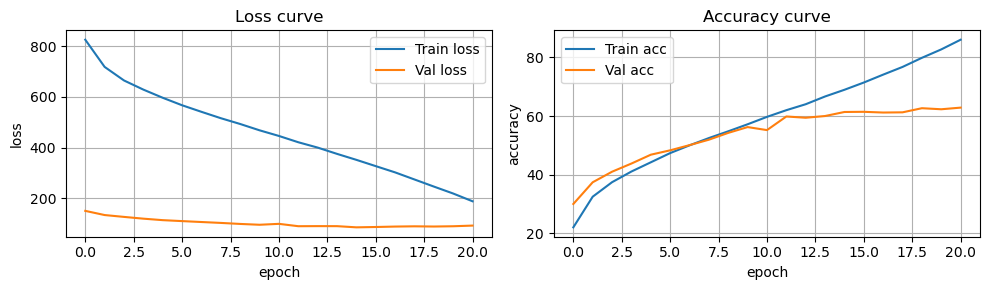

In [11]:

import matplotlib.pyplot as plt
plt.figure(figsize = (10,3))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label = 'Train loss')
plt.plot(range(len(test_losses)), test_losses, label = 'Val loss')
plt.title('Loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_accs, label = 'Train acc')
plt.plot(range(len(test_losses)), test_accs, label = 'Val acc')
plt.title('Accuracy curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

done


Number of parameters:  11173962
Epoch 0, Train loss 1.9902066746941003, Test loss 1.7035919427871704
Epoch 1, Train loss 1.6745598771992851, Test loss 1.5216001477211145
Epoch 2, Train loss 1.5205875904968633, Test loss 1.403229348978419
Epoch 3, Train loss 1.400783354668971, Test loss 1.3252996137947033
Epoch 4, Train loss 1.2948132839501667, Test loss 1.2826783414099627
Epoch 5, Train loss 1.1978501484674566, Test loss 1.3470595858658954
Epoch 6, Train loss 1.099954070718697, Test loss 1.6947776830879746
Epoch 7, Train loss 1.0096933765484548, Test loss 1.467735649673802
Epoch 8, Train loss 0.916751261105013, Test loss 1.312023409612619
Epoch 9, Train loss 0.8189468559096841, Test loss 1.3116138581257717
Epoch 10, Train loss 0.7134648416658191, Test loss 1.388568262006067
Epoch 11, Train loss 0.6071600317573913, Test loss 1.3607884546753708
Epoch 12, Train loss 0.4968853428616853, Test loss 1.3561915333863277
Epoch 13, Train loss 0.3926280567903653, Test loss 2.4584409294614367
Epoch

KeyboardInterrupt: 

In [12]:
correct = 0
total = 0
model.eval()
for i, data in  enumerate(testDataLoader):
  images, labels = data
  images = images.cuda()
  labels = labels.cuda()
  with torch.no_grad():
    predicted_output = model(images)
    _, predicted = torch.max(predicted_output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy of the network on the test images: %d %%' % (100 * accuracy))

Accuracy of the network on the test images: 60 %


In [ ]:
model = ResNet34().cuda()
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=.01)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: ", num_params)

In [7]:
# CHECKING DATA
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dat = unpickle('cifar-10-batches-py/data_batch_1')[b'labels']
data = unpickle('cifar-10-batches-py/data_batch_1')[b'data']

key = unpickle('cifar-10-batches-py/data_batch_5').keys()
print(dat)
print(data)

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8, 7, 1, 3, 0, 

In [14]:

train_loss_history = []
test_loss_history = []
matches = 0
total = 0

# for epoch in range(3):
#   train_loss = 0.0
#   test_loss = 0.0

#   model.train()
#   for i, data in enumerate(zip(trainDataLoader, trainDataLoaderLabels)):
#     images, labels = data
#     images = images.cuda()
#     labels = labels.cuda()
#     optimizer.zero_grad() # zero out any gradient values from the previous iteration
#     predicted_output = model(images) # forward propagation
#     fit = loss(predicted_output, labels)  # calculate our measure of goodness
#     fit.backward() # backpropagation
#     optimizer.step() # update the weights of our trainable parameters
#     train_loss += fit.item()
#   train_loss = train_loss / len(trainDataLoader)
#   train_loss_history += [train_loss]
#   print(f'Epoch {epoch}, Train loss {train_loss}')


for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0

  model.train()
  for i, data in enumerate(zip(trainDataLoader, trainDataLoaderLabels)):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  model.eval()
  for i, data in  enumerate(zip(testDataLoader, testDataLoaderLabels)):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
      _, predicted = torch.max(predicted_output.data, 1)
      matches += (predicted == labels).sum().item()
      total += labels.size(0)
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 2.408974896916343, Test loss 2.310444891073142
Epoch 1, Train loss 2.3071630534613528, Test loss 2.3076204782838277
Epoch 2, Train loss 2.3069299938123855, Test loss 2.3081453924725768
Epoch 3, Train loss 2.306243303181875, Test loss 2.306594730182818
Epoch 4, Train loss 2.3065003708500385, Test loss 2.3049922946152415
Epoch 5, Train loss 2.305988934338855, Test loss 2.3060046533110796
Epoch 6, Train loss 2.3059512913379523, Test loss 2.3048667482509733
Epoch 7, Train loss 2.3065944824682174, Test loss 2.3048215929869635
Epoch 8, Train loss 2.3063857256603972, Test loss 2.306662518507356
Epoch 9, Train loss 2.305964773268346, Test loss 2.306631789845266
Epoch 10, Train loss 2.3064038402893963, Test loss 2.304871546994349
Epoch 11, Train loss 2.3060644648569015, Test loss 2.304071364129425
Epoch 12, Train loss 2.306389828167303, Test loss 2.3045431109750347
Epoch 13, Train loss 2.3061651543278217, Test loss 2.304098223425021
Epoch 14, Train loss 2.3056263835228923, T

In [20]:
import pickle
import pandas as pd
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_images_nl = unpickle('cifar_test_nolabels.pkl')[b'data']

test_images_nl = test_images_nl.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0

test_images_tensor_nl = torch.tensor(test_images_nl, dtype=torch.float32)

testDataLoaderNL = torch.utils.data.DataLoader(test_images_tensor_nl, batch_size=64,shuffle=True)


predictions = []
for image in testDataLoaderNL:
    images = images.cuda()
    # Preprocess the image if necessary
    # Perform inference
    # Here we assume 'resnet' is already loaded and 'image' is preprocessed
    output = model(image)
    # Perform post-processing if necessary
    # Append the prediction to the predictions list
    predictions.append(output.argmax().item())

print(predictions)

# Get predictions from your model
# labels = model.predict(images)

# # Create a DataFrame with IDs and labels
# df = pd.DataFrame({
#     'ID': image_ids,
#     'Labels': labels
# })

# # Save the DataFrame to a CSV file
# df.to_csv('predictions.csv', index=False)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle

torch.manual_seed(1024)

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# def load_cifar_batches(files):
#     all_images = []
#     all_labels = []
#     for file in files:
#         with open(file, 'rb') as fo:
#             batch = pickle.load(fo, encoding='bytes')
#         all_images.append(batch[b'data'].reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0)
#         all_labels.append(batch[b'labels'])
#     return np.concatenate(all_images), np.concatenate(all_labels)

def load_cifar_batch(file, transform=None):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    images = batch[b'data']
    if len(batch) > 2:
        labels = batch[b'labels']
    num_images = images.shape[0]
    
    # Reshape the images into the correct format: NxCxHxW
    images = images.reshape((num_images, 3, 32, 32)).astype(np.float32) / 255.0
    
    # Convert images to a tensor
    images_tensor = torch.tensor(images, dtype=torch.float32)
    
    # Apply transformations if any
    if transform is not None:
        images_tensor = transform(images_tensor)
    if len(batch) > 2:
        return images_tensor, torch.tensor(labels, dtype=torch.long)

    return image_tensor


# train_transform = transforms.Compose([
#     # transforms.RandomCrop(32, padding=4), # Apply random crops
#     # transforms.ToTensor(), # Convert images to PyTorch tensors
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize images
#     # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])

# test_transform = transforms.Compose([
#     # transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transformation for train data 
train_transform = transforms.Compose([
    transforms.RandomRotation(10), # Add random rotation with 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    transforms.RandomHorizontalFlip(), #apply horizontal flipping
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# batch_files = ['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5']
# train_images_dict, train_labels = load_cifar_batches(batch_files)

# # print(len(train_images_dict))
# train_images = train_images_dict.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0 
# # train_labels = train_labels_dict[b'labels']

# train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
# train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# trainDataLoader = torch.utils.data.DataLoader(train_images_tensor, batch_size=64,shuffle=True)
# trainDataLoaderLabels = torch.utils.data.DataLoader(train_labels_tensor, batch_size=64,shuffle=True)

# ~~~~~~~~~~~~~~~~

# batch_1_dict = load_cifar_batch('cifar-10-batches-py/data_batch_3')
# train_images = batch_1_dict[b'data'].reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0 
# train_labels = batch_1_dict[b'labels']



# ~~~~~~~~~~~~~~~~

# batch_files = ['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5']
# trainarr = None
# trainlabel = None

# for file in batch_files:
#     # Load CIFAR-10 batch
#     batch_data = load_cifar_batch(file)
    
#     # Extract images and labels
#     images = batch_data[b'data']  # Assuming 'data' contains the images
#     labels = batch_data[b'labels']  # Assuming 'labels' contains the corresponding labels
    
#     # Reshape images to (-1, 3, 32, 32) and normalize
#     images = images.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0
    
#     # Append images and labels to trainarr and trainlabel respectively
#     if trainarr is None:
#         trainarr = images
#         trainlabel = labels
#     else:
#         trainarr = np.concatenate((trainarr, images), axis=0)
#         trainlabel = np.concatenate((trainlabel, labels), axis=0)

batch_files = ['cifar-10-batches-py/data_batch_1', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_5']
trainarr = None
trainlabel = None

for file in batch_files:
    # Load CIFAR-10 batch
    batch_images, batch_labels = load_cifar_batch(file, transform=train_transform)
    
    # Reshape images to (-1, 3, 32, 32) and normalize
    # batch_images = batch_images.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0
    
    # Append images and labels to trainarr and trainlabel respectively
    if trainarr is None:
        trainarr = batch_images
        trainlabel = batch_labels
    else:
        trainarr = np.concatenate((trainarr, batch_images), axis=0)
        trainlabel = np.concatenate((trainlabel, batch_labels), axis=0)


train_images_tensor = torch.tensor(trainarr, dtype=torch.float32)
train_labels_tensor = torch.tensor(trainlabel, dtype=torch.long)


trainDataLoader = torch.utils.data.DataLoader(train_images_tensor, batch_size=64,shuffle=True)
trainDataLoaderLabels = torch.utils.data.DataLoader(train_labels_tensor, batch_size=64,shuffle=True)

# ~~~~~~~~~~~~~~~~



# testdata = load_cifar_batch('cifar-10-batches-py/test_batch')
# test_images = testdata[b'data'].reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0 
# test_labels = testdata[b'labels']

test_images, test_labels = load_cifar_batch('cifar-10-batches-py/test_batch', transform=test_transform)

# test_images = test_images.reshape((-1, 3, 32, 32)).astype(np.float32) / 255.0

# test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
# test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)


testDataLoader = torch.utils.data.DataLoader(test_images, batch_size=64,shuffle=True)
testDataLoaderLabels = torch.utils.data.DataLoader(test_labels, batch_size=64,shuffle=True)


images = next(iter(trainDataLoader))
labels = next(iter(trainDataLoaderLabels))
print(len(trainDataLoader))


In [ ]:
# def load_cifar_batch(file, transform=None):
#     with open(file, 'rb') as fo:
#         batch = pickle.load(fo, encoding='bytes')
#     images = batch[b'data']
#     labels = batch[b'labels']
#     num_images = images.shape[0]
    
#     # Reshape the images into the correct format: NxCxHxW
#     images = images.reshape((num_images, 3, 32, 32)).astype(np.float32) / 255.0
    
#     # Convert images to a tensor
#     images_tensor = torch.tensor(images, dtype=torch.float32)
    
#     # Apply transformations if any
#     if transform is not None:
#         images_tensor = transform(images_tensor)

#     return images_tensor, torch.tensor(labels, dtype=torch.long)
# # Define tensor transformations
# tensor_transform = transforms.Compose([
#     # Note: transforms for tensors here. Ensure they operate on tensors
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# # Example of loading a batch with transformations
# batch_images, batch_labels = load_cifar_batch('cifar-10-batches-py/data_batch_1', transform=tensor_transform)


In [7]:
import gc
gc.collect()

1662